# Imports

In [1]:
import numpy as np
import scipy as sp
import scipy.optimize
import matplotlib.pyplot as plt

# Import data

https://www.cset-foretell.com/questions/96-what-will-be-the-value-in-dollars-of-all-chinese-imports-of-semiconductor-chips-in-2021

In [2]:
# Data from https://docs.google.com/spreadsheets/d/1EcDCcmAZEBtAinKiihbJTQyUUHcSvCJ9Qtqb55TCKDY/edit#gid=692543022
data = {"date": np.array([2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]) - 2011,
       "quant": np.array([171142150713, 192967176584, 232078243157, 218520292429, 230657123275, 
                          227616904239, 261161384489, 312735353341, 305897834388]) * 1e-9}

xlabel = 'Time [years since 2011]'
ylabel = 'Value of chip imports [bn $]'

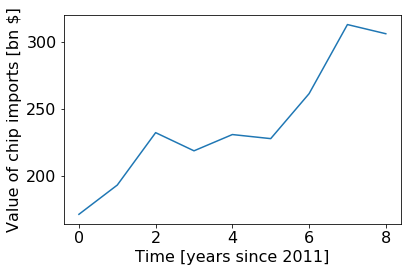

In [3]:
plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(1,1)

ax.plot(data['date'], data['quant'])
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)

plt.tight_layout()

# Generate trend-fit values, linear

In [4]:
def outside_func(t, m, b):
    return m*t + b

In [5]:
slope_guess = 20 # 20 bn $ / year
offs_guess = 150
popt, pcov = sp.optimize.curve_fit(outside_func, data['date'], data['quant'], p0=[slope_guess, offs_guess])
perr = np.sqrt(np.diag(pcov)) # The standard deviations of the parameters

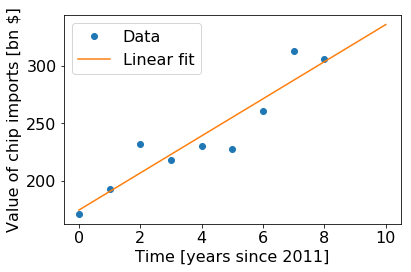

In [6]:
fig, ax = plt.subplots(1,1)

t_final = 10
fit_label = 'Linear fit'
ax.plot(data['date'], data['quant'], 'o', label='Data')
t_plot = np.linspace(0, t_final, 100)
ax.plot(t_plot, outside_func(t_plot, *popt), label=fit_label)
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)

ax.legend()

plt.tight_layout()

In [7]:
outside_func(t_final, *popt)

335.7564006794689

## Monte Carlo of trends

I think with the fit we could probably just build up the probability density function P(y) =  Pr(f(x) = y) for the ranges of y we care about, just given our fit parameters and covariance matrix. However, I think an equivalent way to do this is to just run a monte carlo simulation were we randomly sample from our fit parameters, drawing the fit parameters form the multivariate gaussian distribution defined by popt and pcov. Then bin the value of f(x) that we get from the simulation.

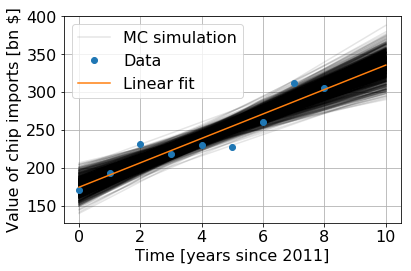

In [8]:
# Generate fits

n_fits = 1000
fit_params_gen = np.random.multivariate_normal(popt, pcov, n_fits)


fit_params = fit_params_gen
# Comment out the line above and uncomment the below lines to clean to fit based on some criteria. 
# Be very careful throwing only a lot of data though!!
# fit_params = []
# n_removed = 0
# for fit_list in fit_params_gen:
#     if fit_list[0] < 0:
#         n_removed += 1
#         n_fits -= 1
#     else:
#         fit_params.append(fit_list)
# print('Generated %i plots, discarded %i' %(n_fits + n_removed, n_removed))


# Plot MC simualtions and build MC data
fig, ax_mc = plt.subplots(1,1)

final_vals = []
for i, popt_mc in enumerate(fit_params):
    label = 'MC simulation' if i == 0 else None 
    t_plot = np.linspace(0, t_final, 100)
    ax_mc.plot(t_plot, outside_func(t_plot, *popt_mc), 'k', alpha=0.1, label=label)
    
    final_vals.append(outside_func(np.array([t_final]), *popt_mc)[0])
    
# Plot original data and fit
ax_mc.plot(data['date'], data['quant'], 'o', label='Data')
t_plot = np.linspace(0, t_final, 100)
ax_mc.plot(t_plot, outside_func(t_plot, *popt), label=fit_label)

ax_mc.set_xlabel(xlabel)
ax_mc.set_ylabel(ylabel)

ax_mc.grid()
ax_mc.legend()

plt.tight_layout()

## Including histogram

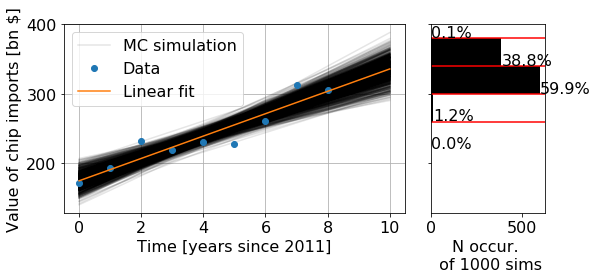

In [9]:
# Plot MC simualtions and build MC data
cset_boundaries = [260, 300, 340, 380]

fig, [ax_mc, ax_hist] = plt.subplots(1, 2, figsize=(8, 4), gridspec_kw={'width_ratios': [3, 1]}, sharey=True)

for i, popt_mc in enumerate(fit_params):
    label = 'MC simulation' if i == 0 else None 
    t_plot = np.linspace(0, t_final, 100)
    ax_mc.plot(t_plot, outside_func(t_plot, *popt_mc), 'k', alpha=0.1, label=label)
        
# Plot original data and fit
ax_mc.plot(data['date'], data['quant'], 'o', label='Data')
t_plot = np.linspace(0, t_final, 100)
ax_mc.plot(t_plot, outside_func(t_plot, *popt), label=fit_label)

# for boundary in cset_boundaries:
#     ax_mc.axhline(boundary, color='r', linewidth=0.3)

ax_mc.set_xlabel(xlabel)
ax_mc.set_ylabel(ylabel)
# ax_mc.set_yscale('log')

ax_mc.grid()
ax_mc.legend()




# Plot histogram
bin_min = min(final_vals) if min(final_vals) < min(cset_boundaries) else min(cset_boundaries) - np.diff(cset_boundaries)[0]
bin_max = max(final_vals) if max(final_vals) > max(cset_boundaries) else max(cset_boundaries) + np.diff(cset_boundaries)[-1]

bins = np.concatenate([[bin_min], cset_boundaries, [bin_max]])

n, bins, patches = ax_hist.hist(np.array(final_vals), bins, color='k', orientation='horizontal')
# ax_hist.set_ylim(ax_mc.get_ylim())

ax_hist.set_xlabel('N occur. \n of {} sims'.format(n_fits))

for boundary in cset_boundaries:
    ax_hist.axhline(boundary, color='r')
    
text_offset = (max(bins) - min(bins)) / 100
percentages = [n_val / n_fits * 100 for n_val in n]
for n_val, bin_min, percent in zip(n, bins[:-1], percentages):
    ax_hist.text(n_val, bin_min + text_offset, '%.1f%%' %(percent))


plt.tight_layout()

In [10]:
percentages_lin = percentages
final_vals_lin = final_vals

# Generate final forcast

Before I saw any data, I would have put equal confidence in each of the 5 bins, so my prior was {0.2, 0.2, 0.2, 0.2, 0.2}.

I then tried to incorporate information about historical trends alone by doing a linear fit on the data, and estimating the distribution for 2021 given the uncertainty in this linear fit. From this curve fitting, my best estimate of the probabilities of the trend reaching the values {<260, 260-300, 300-340, 340-380, >380} is {0%, 1.3%, 59%, 39.7%, 0%} respectively (For how I arrived at these, see https://github.com/cphenicie/forecasts/tree/main/Foretell in the file 20201118_value-of-Chinese-chip-imports). 

I arbitrarily assigned 50% confidence to my prior values and 50% confidence to these trend-fits values. I then arrived at updated values by taking the mean of the prior with the trend-fit value (0.5 * [prior] + (1-0.5) * [trend-fit value]), and then normalizing the resulting distribution

In the future, I will try to update these priors as I learn more about the specifics of this case

In [11]:
prior = [0.2, 0.2, 0.2, 0.2, 0.2]
fit = [p/100 for p in percentages]
c_fit = 0.5
mean_vals = [(1-c_fit) * p + c_fit * f for p, f in zip(prior, fit)]
final_dist = mean_vals / np.sum(mean_vals)
print('Prior = ', prior)
print('Fit values = ', fit)
print('Final distribution = ', final_dist)

Prior =  [0.2, 0.2, 0.2, 0.2, 0.2]
Fit values =  [0.0, 0.012, 0.599, 0.38800000000000007, 0.001]
Final distribution =  [0.1    0.106  0.3995 0.294  0.1005]


# Updates based on specifics

## 2021-01-02

Update: My updates on the US exports to China was updated down due to the specifics of the situation, but I think that total Chinese imports will not be affected by this. 

Based off of this article:
- https://foreignpolicy.com/2020/12/14/china-technology-sanctions-huawei-chips-semiconductors/

my understanding is that China has no option but to import chips. If there were sufficient multilateral action from the rest of the world, perhaps there would just be unmet demand in China, but for now I'm going to put more confidence in a continued historical trend, now 66% confident in the trend and 33% confident in a uniform prior

In [12]:
prior = [0.2, 0.2, 0.2, 0.2, 0.2]
fit = [p/100 for p in percentages]
c_fit = 0.66
mean_vals = [(1-c_fit) * p + c_fit * f for p, f in zip(prior, fit)]
final_dist = mean_vals / np.sum(mean_vals)
print('Prior = ', prior)
print('Fit values = ', fit)
print('Final distribution = ', final_dist)

Prior =  [0.2, 0.2, 0.2, 0.2, 0.2]
Fit values =  [0.0, 0.012, 0.599, 0.38800000000000007, 0.001]
Final distribution =  [0.068   0.07592 0.46334 0.32408 0.06866]


## 2021-01-10

Update: I am updating based off of two pieces of information I've picked up in the last week:

1. [The news of NYSE delisting some Chinese telecoms companies](https://www.bloomberg.com/news/articles/2021-01-08/behind-the-nyse-s-swerves-on-delisting-china-stocks-quicktake)

2. [The news of strong demand for semiconductors in 2021, at least indirectly of this from the unmet demand of car companies](https://www.ft.com/content/e264fd41-7ee9-4fba-be3c-21446298efd9)


The (1) makes me think that, on the whole at least, business between US companies and Chinese companies will decline a little bit. 

(2) Makes me think that it's not obvious how COVID will affect the sales/supply/demand of semiconductors in 2021 compared to previous years, so I will refrain from updating historical trends based on COVID reasoning for now

So, for chip imports to China, I will apply a weak update downwards, arbitrarily by 0.5%, since I'm not sure what percentage of China's chip imports are from the US, and I think there are some degrees of separation between telecoms equipment and chips in general

Further, I will put a little more faith (70%, up from 30%) in the historical trends, based on the (admittedly weak) evidence from (2)

In [16]:
update_20210102 = 1
update_20210110 = 0.995

update = update_20210102 * update_20210110

# Plot MC simualtions and build MC data
cset_boundaries = [260, 300, 340, 380]


bin_min = min(final_vals) * update if min(final_vals) * update < min(cset_boundaries) else min(cset_boundaries) - np.diff(cset_boundaries)[0]
bin_max = max(final_vals) * update if max(final_vals) * update > max(cset_boundaries) else max(cset_boundaries) + np.diff(cset_boundaries)[-1]

bins = np.concatenate([[bin_min], cset_boundaries, [bin_max]])

# Linear sims
n, bins = np.histogram(np.array(final_vals) * update, bins)
percentages_linear = n / len(final_vals) * 100

# # Exp sims
# n, bins = np.histogram(np.array(final_vals_exp) * update, bins)
# percentages_exp = n / len(final_vals_exp) * 100

In [17]:
prior = [0.2, 0.2, 0.2, 0.2, 0.2]
fit_lin = [p/100 for p in percentages_linear]
# fit_exp = [p/100 for p in percentages_exp]
mean_vals = [(0.3) * p + 0.7* f_l for p, f_l in zip(prior, fit_lin)]
dist_20210110 = mean_vals / np.sum(mean_vals)
print('Prior = ', prior)
print('Fit values = ', fit_lin)
print('distribution on 20210110 ', dist_20210110)

Prior =  [0.2, 0.2, 0.2, 0.2, 0.2]
Fit values =  [0.0, 0.019, 0.627, 0.353, 0.001]
distribution on 20210110  [0.06   0.0733 0.4989 0.3071 0.0607]
